# Extrapolation method for strain result of a 2D element {#extrapolation_test_strain_2Delement}

This example shows how to compute the stress nodal components from
Gaussian points (integration points) for a 2D element using
extrapolation.

Extrapolate results available at Gaussian or quadrature points to nodal
points for a field or fields container. The available elements are:

-   Linear quadrangle
-   Parabolic quadrangle
-   Linear hexagonal
-   Quadratic hexagonal
-   Linear tetrahedral
-   Quadratic tetrahedral

Here are the steps for extrapolation:

1.  Get the data source\'s solution from the integration points. (This
    result file was generated with the Ansys Mechanical APDL (MAPDL)
    option `ERESX, NO`).
2.  Use the extrapolation operator to compute the nodal elastic strain.
3.  Get the result for nodal elastic strain from the data source. The
    analysis was computed by MAPDL.
4.  Compare the result for nodal elastic strain from the data source and
    the nodal elastic strain computed by the extrapolation method.


In [1]:
from ansys.dpf import core as dpf
from ansys.dpf.core import examples

Get the data source\'s analyse of integration points and data source\'s
analyse reference


In [2]:
datafile = examples.download_extrapolation_2d_result()

# integration points (Gaussian points)
data_integration_points = datafile["file_integrated"]
data_sources_integration_points = dpf.DataSources(data_integration_points)

# reference
dataSourceref = datafile["file_ref"]
data_sources_ref = dpf.DataSources(dataSourceref)

# get the mesh
model = dpf.Model(data_integration_points)
mesh = model.metadata.meshed_region

# Extrapolate from integration points for elastic strain result

This example uses the `gauss_to_node_fc` operator to compute nodal
component elastic strain results from the elastic strain at the
integration points.


In [3]:
# Create elastic strain operator to get strain result of integration points
strainop = dpf.operators.result.elastic_strain()
strainop.inputs.data_sources.connect(data_sources_integration_points)
strain = strainop.outputs.fields_container()

# Nodal elastic strain result of integration points:

> The command `ERESX,NO` in MAPDL is used to copy directly the Gaussian
> (integration) points results to the nodes, instead of the results at
> nodes or elements (which are an interpolation of results at a few
> Gaussian points).
>
> The following plot shows the nodal values that are the averaged values
> of elastic strain at each node. The value shown at the node is the
> average of the elastic strains from the Gaussian points of each
> element that it belongs to.


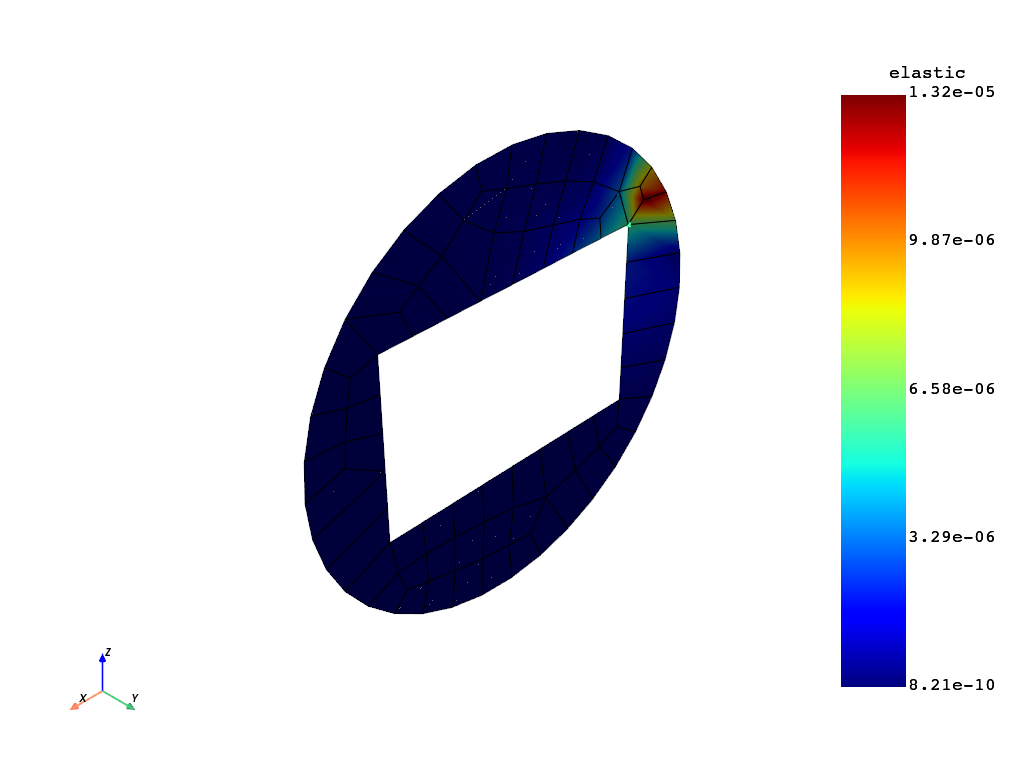

In [4]:
# plot
strain_nodal_op = dpf.operators.averaging.elemental_nodal_to_nodal_fc()
strain_nodal_op.inputs.fields_container.connect(strain)
mesh.plot(strain_nodal_op.outputs.fields_container())

Create the `gauss_to_node_fc` operator and compute nodal component
elastic strain by applying the extrapolation method.


In [5]:
ex_strain = dpf.operators.averaging.gauss_to_node_fc()
# connect mesh
ex_strain.inputs.mesh.connect(mesh)
# connect fields container elastic strain
ex_strain.inputs.fields_container.connect(strain)
# get output
fex = ex_strain.outputs.fields_container()

# Elastic strain result of reference Ansys Workbench


In [6]:
# Strain from file dataSourceref
strainop_ref = dpf.operators.result.elastic_strain()
strainop_ref.inputs.data_sources.connect(data_sources_ref)
strain_ref = strainop_ref.outputs.fields_container()

# Plot

Show plots of extrapolation\'s elastic strain result and reference\'s
elastic strain result


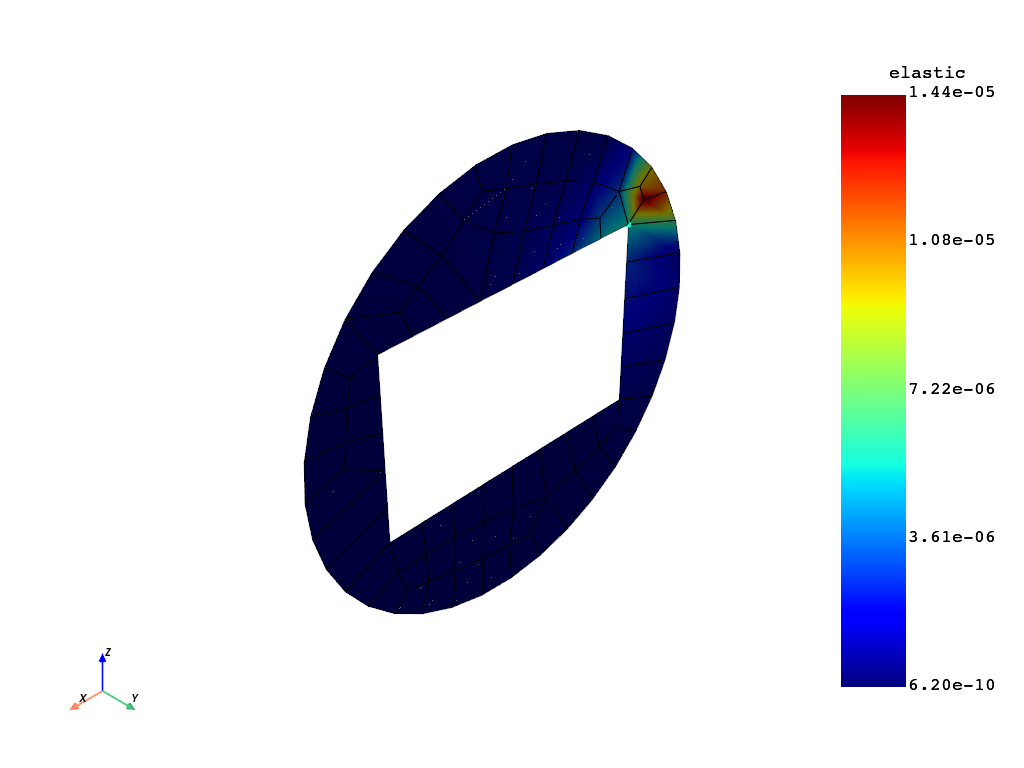

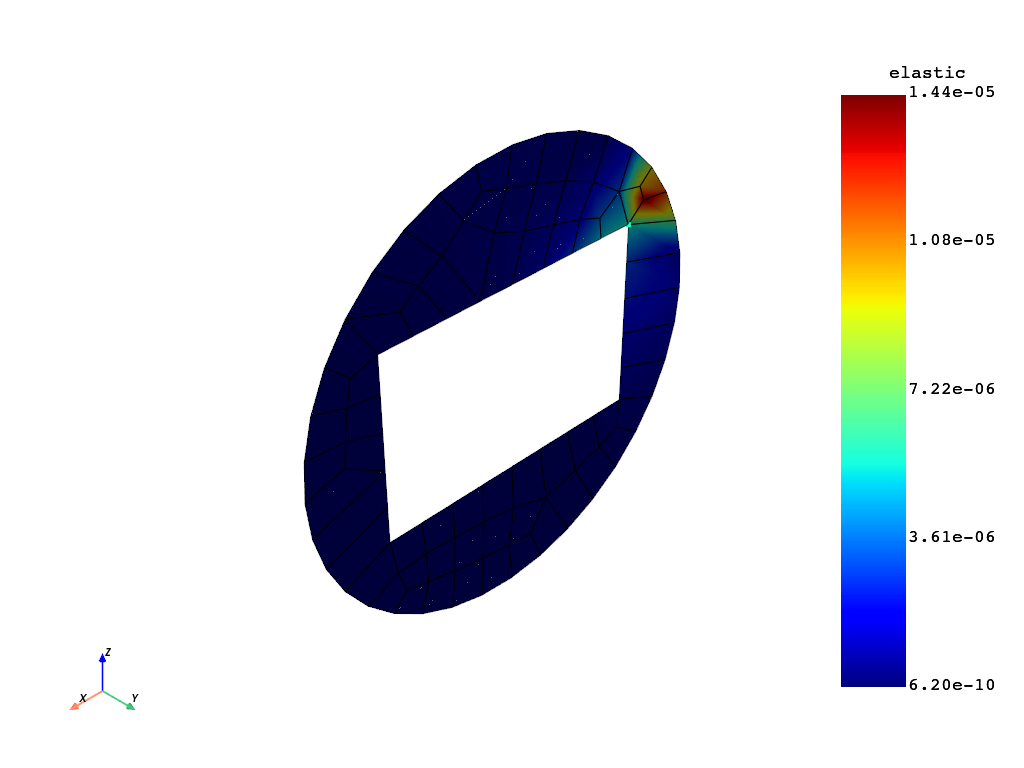

In [7]:
# extrapolation
fex_nodal_op = dpf.operators.averaging.elemental_nodal_to_nodal_fc()
fex_nodal_op.inputs.fields_container.connect(fex)
mesh.plot(fex_nodal_op.outputs.fields_container())
# reference
strain_ref_nodal_op = dpf.operators.averaging.elemental_nodal_to_nodal_fc()
strain_ref_nodal_op.inputs.fields_container.connect(strain_ref)
mesh.plot(strain_ref_nodal_op.outputs.fields_container())

# Comparison

Compare the elastic strain result computed by extrapolation and
reference\'s result. Check if the two fields containers are identical.
The relative tolerance is set to 1e-14. The smallest value that is to be
considered during the comparison step : all the `abs(values)` in the
field less than 1e-2 are considered null.


In [8]:
# operator AreFieldsIdentical_fc
op = dpf.operators.logic.identical_fc()
op.inputs.fields_containerA.connect(fex_nodal_op)
op.inputs.fields_containerB.connect(strain_ref_nodal_op)
op.inputs.tolerance.connect(1.0e-14)
op.inputs.small_value.connect(0.01)
print(op.outputs.boolean())

True


Compute absolute and relative errors


In [9]:
abs_error_sqr = dpf.operators.math.sqr_fc()
abs_error = dpf.operators.math.sqrt_fc()
error = strain_ref_nodal_op - fex_nodal_op
abs_error_sqr.inputs.fields_container.connect(error)
abs_error.inputs.fields_container.connect(abs_error_sqr)

divide = dpf.operators.math.component_wise_divide()
divide.inputs.fieldA.connect(strain_ref_nodal_op - fex_nodal_op)
divide.inputs.fieldB.connect(strain_ref_nodal_op)
rel_error = dpf.operators.math.scale()
rel_error.inputs.field.connect(divide)
rel_error.inputs.ponderation.connect(1.0)

Plot absolute and relative errors. The absolute value is the order of
1e-13, which is very small when compared to the magnitude of 1e-5 of the
displacements. This is reflected in the relative error plot, where the
errors are found to be below 1.1e-5%. The result of these plots can be
used to set the tolerances for the
`identical_fc <ansys.dpf.core.operators.logic.identical_fc>`{.interpreted-text
role="class"} operator.


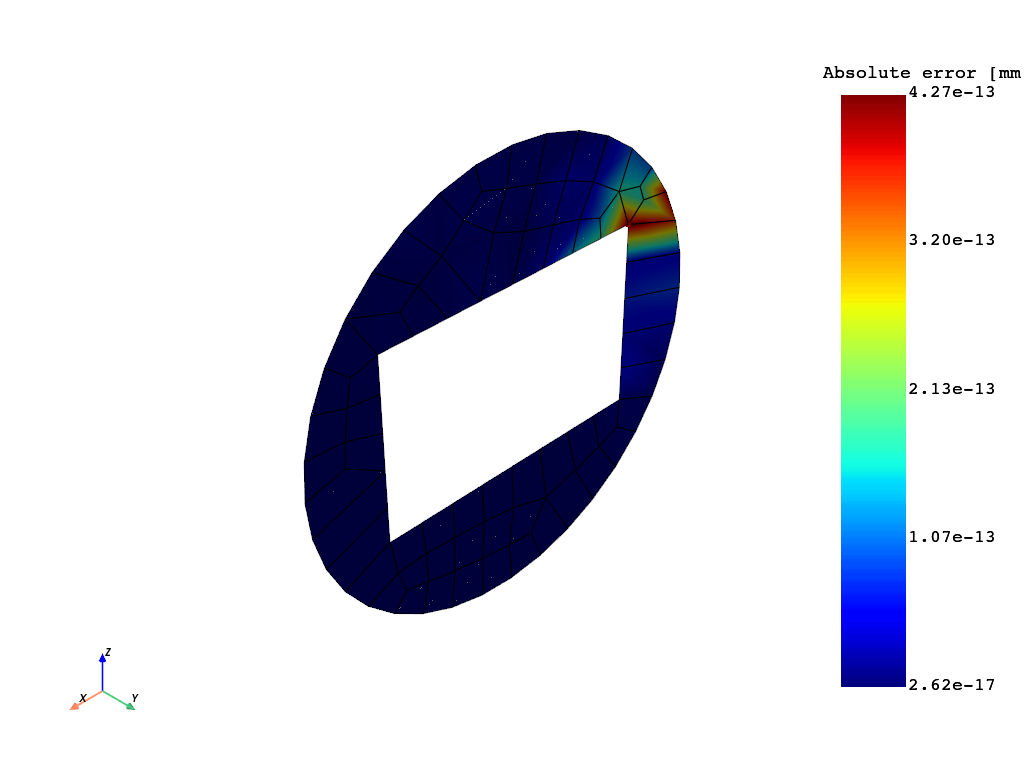

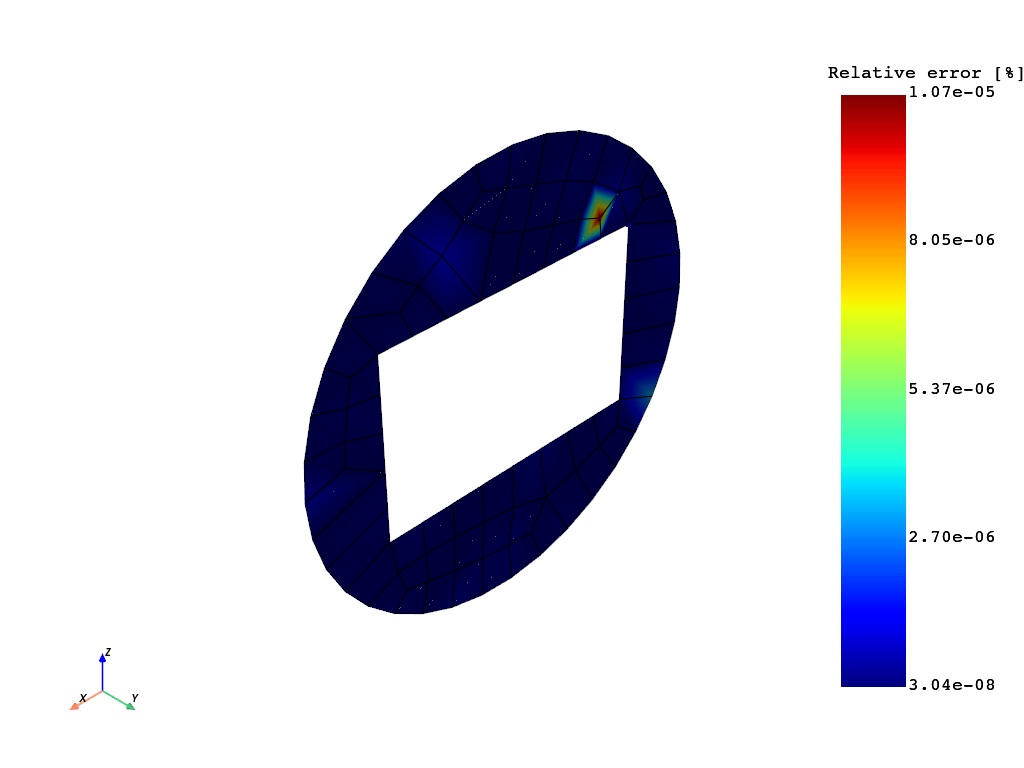

In [10]:
mesh.plot(abs_error.eval(), scalar_bar_args={"title": "Absolute error [mm]"})
mesh.plot(rel_error.eval(), scalar_bar_args={"title": "Relative error [%]"})